In [1]:
!wget https://raw.githubusercontent.com/omniscientoctopus/Physics-Informed-Neural-Networks/7d26e55cc665b79b652b226860177fa4defe9190/PyTorch/Burgers\'%20Equation/Data/burgers_shock_mu_005_pi.mat

--2025-01-20 07:08:42--  https://raw.githubusercontent.com/omniscientoctopus/Physics-Informed-Neural-Networks/7d26e55cc665b79b652b226860177fa4defe9190/PyTorch/Burgers'%20Equation/Data/burgers_shock_mu_005_pi.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157672 (154K) [application/octet-stream]
Saving to: ‘burgers_shock_mu_005_pi.mat’

burgers_shock_mu_00 100%[===================>] 153.98K  --.-KB/s    in 0.009s  

2025-01-20 07:08:43 (16.6 MB/s) - ‘burgers_shock_mu_005_pi.mat’ saved [157672/157672]



In [68]:
# !wget https://raw.githubusercontent.com/broccubali/PINNs/siddhi/pde-gen/burgers/data/burgerClean.npy
# !wget https://raw.githubusercontent.com/broccubali/PINNs/master/pde-gen/burgers/data/burgerExponential.npy
!wget https://raw.githubusercontent.com/broccubali/PINNs/siddhi/pde-gen/burgers/data/burgerSkewedNormal.npy
!wget https://raw.githubusercontent.com/broccubali/PINNs/master/pde-gen/burgers/data/t_coordinate.npy
!wget https://raw.githubusercontent.com/broccubali/PINNs/master/pde-gen/burgers/data/x_coordinate.npy

--2025-01-20 07:44:51--  https://raw.githubusercontent.com/broccubali/PINNs/siddhi/pde-gen/burgers/data/burgerSkewedNormal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823424 (804K) [application/octet-stream]
Saving to: ‘burgerSkewedNormal.npy’

burgerSkewedNormal. 100%[===================>] 804.12K  --.-KB/s    in 0.007s  

2025-01-20 07:44:52 (118 MB/s) - ‘burgerSkewedNormal.npy’ saved [823424/823424]

--2025-01-20 07:44:52--  https://raw.githubusercontent.com/broccubali/PINNs/master/pde-gen/burgers/data/t_coordinate.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP re

# pinn class

In [9]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm


class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList(
            [
                (
                    nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                    if i % 2 == 0
                    else nn.Tanh()
                )
                for i in range(20)
            ]
        )
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    # ic and bc is of shape [x, 3]. first two columns is x and t, last column is u.
    # predict using [:2], calc loss using [2]
    def loss_fn(self, cond):
        u = torch.reshape(cond[:, 2], (-1, 1))
        u_pred = self.forward(cond[:, :2])
        return self.loss(u_pred, u)

    def residual_loss(self, x_f_train, nu, fhat):
        x = x_f_train[:, 0]
        t = x_f_train[:, 1]
        g = x_f_train.clone()
        g.requires_grad = True
        u_pred = self.forward(g)
        u_x_t = torch.autograd.grad(
            u_pred,
            g,
            torch.ones([x_f_train.shape[0], 1]).to("cuda"),
            retain_graph=True,
            create_graph=True,
        )[0]
        u_xx_tt = torch.autograd.grad(
            u_x_t, g, torch.ones(x_f_train.shape).to("cuda"), create_graph=True
        )[0]
        u_x = u_x_t[:, [0]]
        u_t = u_x_t[:, [1]]
        u_xx = u_xx_tt[:, [0]]
        return self.loss(u_t + u_pred * u_x - (nu * u_xx), fhat)

    def total_loss(self, x_f_train, ic_bc, nu, fhat):
        return self.loss_fn(ic_bc) + self.residual_loss(x_f_train, nu, fhat)

    def train_model(self, x_f_train, ic_bc, nu, epochs=1000, lr=0.001):
        fhat = torch.zeros(x_f_train.shape[0], 1, device="cuda")
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            loss = self.total_loss(x_f_train, ic_bc, nu, fhat)
            loss.backward()
            self.optimizer.step()


model = PINN(input_size=2, hidden_size=20, output_size=1).to("cuda")
print(model)

PINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): Tanh()
    (18): Linear(in_features=20, out_features=20, bias=True)
    (19): Tanh()
    (20): Linear(in_features=20, out_features=1, bias=True)
  )
  (loss): MSELoss()
)


# load data

In [18]:
data = loadmat("data/noisy.mat")
u = data["usol"]
x = data["x"]
t = data["t"]

# u = np.load("burgerSkewedNormal.npy")
# x = np.load("x_coordinate.npy")
# t = np.load("t_coordinate.npy")[:-1]
x = torch.tensor(x, dtype=torch.float32)
t = torch.tensor(t, dtype=torch.float32)
u = torch.tensor(u, dtype=torch.float32)
# form a meshgrid, where X contains all the x points from -1 to 1, 100 times for 100 time steps.
# T contains all 100 time steps from 0 to 1, 256 times for 256 x points
X, T = np.meshgrid(x, t)
X.shape, T.shape, u.shape

((100, 256), (100, 256), torch.Size([100, 256]))

# initial and boundary conditions

In [19]:
# initial conditions, x at t=0. shape of 256, 1
xic, tic, uic = X[0, :], T[0, :], u[0, :]
# bc1, x=1, t goes from 0 to 1. shape of 100, 1
xbc1, tbc1, ubc1 = X[:, 0], T[:, 0], u[:, 0]
# bc2, x=-1, t goes from 0 to 1. shape of 100, 1
xbc2, tbc2, ubc2 = X[:, -1], T[:, -1], u[:, -1]

# Convert xic, tic, xbc1, tbc1, xbc2, and tbc2 to PyTorch tensors
xic = torch.tensor(xic, dtype=torch.float32)
tic = torch.tensor(tic, dtype=torch.float32)
xbc1 = torch.tensor(xbc1, dtype=torch.float32)
tbc1 = torch.tensor(tbc1, dtype=torch.float32)
xbc2 = torch.tensor(xbc2, dtype=torch.float32)
tbc2 = torch.tensor(tbc2, dtype=torch.float32)
# stack em all together so we can pass it to the loss function. Shape of [n, 3]
ic = torch.stack([xic, tic, uic], dim=1)
bc1 = torch.stack([xbc1, tbc1, ubc1], dim=1)
bc2 = torch.stack([xbc2, tbc2, ubc2], dim=1)
bc = torch.vstack([bc1, bc2])

ic.shape, bc.shape

(torch.Size([256, 3]), torch.Size([200, 3]))

# collocation points

In [ ]:
# !pip install pyDOE

In [21]:
from pyDOE import lhs

X_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
lb = X_u_test[0]
ub = X_u_test[-1]
lb, ub
idx = np.random.choice(456, 100, replace=False)
ic_bc_train = np.vstack([ic, bc])[idx, :]
X_f_train = lb + (ub - lb) * lhs(2, 10000)
X_f_train = np.vstack((X_f_train, ic_bc_train[:, :2]))
X_f_train.shape, ic_bc_train.shape


((10100, 2), (100, 3))

In [22]:
device = torch.device("cuda")
X_f_train = torch.tensor(X_f_train, dtype=torch.float32, device=device)
ic_bc_train = torch.tensor(ic_bc_train, dtype=torch.float32, device=device)

In [23]:
model.train_model(X_f_train, ic_bc_train, 0.01 / np.pi, 10000, 0.001)

100%|██████████| 10000/10000 [00:54<00:00, 183.17it/s]


In [24]:
u_pred = (
    model.forward(torch.tensor(X_u_test, dtype=torch.float32, device=device))
    .cpu()
    .detach()
)
u_pred = u_pred.reshape(X.shape)
loss = model.loss(u_pred, u)
loss

tensor(0.1122)

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm


def visualize_burgers(xcrd, data, path):
    """
    This function animates the Burgers equation

    Args:
    path : path to the desired file
    param: PDE parameter of the data shard to be visualized
    """
    fig, ax = plt.subplots()
    ims = []

    for i in tqdm(range(data.shape[0])):
        if i == 0:
            im = ax.plot(xcrd, data[i].squeeze(), animated=True, color="blue")
        else:
            im = ax.plot(xcrd, data[i].squeeze(), animated=True, color="blue")
        ims.append([im[0]])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    writer = animation.PillowWriter(fps=15, bitrate=1800)
    ani.save(path, writer=writer)
    plt.close(fig)


visualize_burgers(x, u_pred, "predicted_solution.gif")
visualize_burgers(x, u, "true_solution.gif")

100%|██████████| 100/100 [00:00<00:00, 5838.48it/s]


<ipython-input-103-1dd113937704>:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


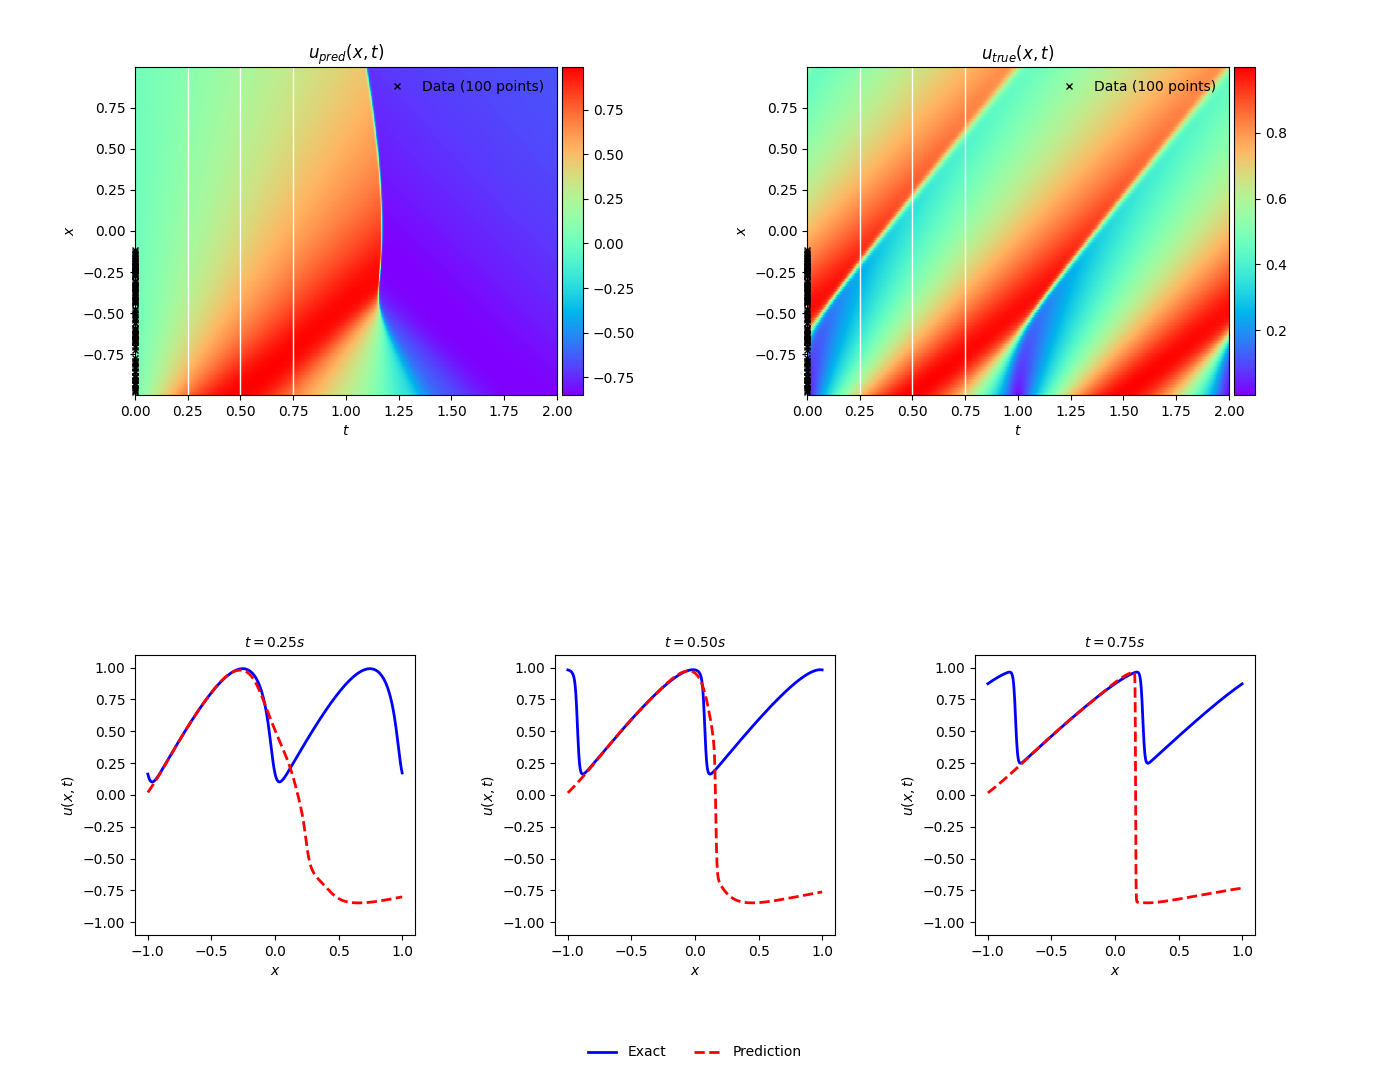

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

def solutionplot(u_pred, X_u_train, u_train, T, X, u, x, t, filename='Burgers.png'):
    fig = plt.figure(figsize=(14, 12))

    ####### Heatmap of u_pred ####################
    ax1 = fig.add_subplot(211)
    ax1.axis('off')
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.1, right=0.9, wspace=0.5)

    ax1 = plt.subplot(gs0[:, 0])
    h_pred = ax1.imshow(u_pred, interpolation='nearest', cmap='rainbow',
                        extent=[T.min(), T.max(), X.min(), X.max()],
                        origin='lower', aspect='auto')
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h_pred, cax=cax1)

    ax1.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label=f'Data ({u_train.shape[0]} points)', markersize=4, clip_on=False)
    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax1.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax1.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax1.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x$')
    ax1.legend(frameon=False, loc='best')
    ax1.set_title('$u_{pred}(x,t)$', fontsize=12)

    ####### Heatmap of u_true ####################
    ax2 = plt.subplot(gs0[:, 1])
    h_true = ax2.imshow(u, interpolation='nearest', cmap='rainbow',
                        extent=[T.min(), T.max(), X.min(), X.max()],
                        origin='lower', aspect='auto')
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h_true, cax=cax2)

    ax2.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label=f'Data ({u_train.shape[0]} points)', markersize=4, clip_on=False)
    ax2.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax2.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax2.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

    ax2.set_xlabel('$t$')
    ax2.set_ylabel('$x$')
    ax2.legend(frameon=False, loc='best')
    ax2.set_title('$u_{true}(x,t)$', fontsize=12)

    ####### Slices of the solution ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    times = [25, 50, 75]
    titles = ['$t = 0.25s$', '$t = 0.50s$', '$t = 0.75s$']

    for i, time in enumerate(times):
        ax = plt.subplot(gs1[0, i])
        ax.plot(x, u[time, :], 'b-', linewidth=2, label='Exact')
        ax.plot(x, u_pred[time, :], 'r--', linewidth=2, label='Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(x,t)$')
        ax.axis('square')
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_title(titles[i], fontsize=10)

        if i == 1:  # Add legend only to the middle plot
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ####### Save the figure ######################
    plt.tight_layout()
    plt.savefig(filename, dpi=500)
    plt.show()

ic_bc_train = ic_bc_train.to("cpu")
solutionplot(u_pred, ic_bc_train[:, :2], ic_bc_train[:, 2], T, X, u, x, t)


In [ ]:
u

tensor([[ 1.2246e-16,  2.4500e-16,  4.6851e-16,  ...,  1.8447e-02,
          1.8232e-02,  1.8023e-02],
        [ 1.7818e-02,  1.7617e-02,  1.7421e-02,  ...,  9.5764e-02,
          9.3473e-02,  9.1289e-02],
        [ 8.9205e-02,  8.7215e-02,  8.5311e-02,  ...,  5.6562e-02,
          5.5985e-02,  5.5420e-02],
        ...,
        [-8.5742e-02, -8.4422e-02, -8.3142e-02,  ..., -3.3497e-02,
         -3.3213e-02, -3.2934e-02],
        [-3.2660e-02, -3.2390e-02, -3.2124e-02,  ..., -2.1484e-02,
         -2.1193e-02, -2.0910e-02],
        [-2.0635e-02, -2.0366e-02, -2.0105e-02,  ..., -3.0488e-16,
         -2.7972e-16, -3.0969e-16]])